In [1]:
from src.utils import audio_utils
import matplotlib.pyplot as plt
import os
import torch
nn = torch.nn
from src.utils import path_utils
import torchinfo
import torchvision

In [12]:
class ClassifDataset(torch.utils.data.Dataset):

  def __init__(self, positive_path, negative_path):
    self.positive_path = positive_path
    self.negative_path = negative_path
    self.positive_files = [file for file in os.listdir(self.positive_path) if file.endswith(".wav")]
    self.negative_files = [file for file in os.listdir(self.negative_path) if file.endswith(".wav")]
    self.reshape_size = (129, 229)
    self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize(self.reshape_size), torchvision.transforms.Normalize((6.9260e-07,), (4.2260e-06,))])

  def __len__(self):
    return len(self.positive_files) + len(self.negative_files)
  
  def __getitem__(self, idx):
    if idx < len(self.positive_files):
      file_path = os.path.join(self.positive_path, self.positive_files[idx])
      data, fs = audio_utils.load_audio_file(file_path)
      _, _, Sxx = audio_utils.compute_spectrogram(data, fs, nperseg=256, noverlap=256//4)
      Sxx = self.transform(Sxx)
      return Sxx, 1
    else:
      file_path = os.path.join(self.negative_path, self.negative_files[idx - len(self.positive_files)])
      data, fs = audio_utils.load_audio_file(file_path)
      _, _, Sxx = audio_utils.compute_spectrogram(data, fs, nperseg=256, noverlap=256//4)
      Sxx = self.transform(Sxx)
      return Sxx, 0

In [13]:
train_dataset = ClassifDataset(path_utils.get_train_test_path(path_utils.get_positive_samples_path(), True), path_utils.get_train_test_path(path_utils.get_negative_samples_path(), True))
test_dataset = ClassifDataset(path_utils.get_train_test_path(path_utils.get_positive_samples_path(), False), path_utils.get_train_test_path(path_utils.get_negative_samples_path(), False))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [14]:
class BasicModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linear = nn.Linear(128, 2)
  
  def forward(self, x):
    x = self.main(x)
    # global average pooling
    x = nn.functional.avg_pool2d(x, kernel_size=x.shape[2:]).view(x.shape[0], -1)
    x = self.linear(x)
    return x


In [15]:
model = BasicModel()
torchinfo.summary(model, input_size=(1, 1, 400, 200))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [16]:
for epoch in range(10):
  print("="*30)
  for i, (x, y) in enumerate(train_dataloader):
    logits = model(x)
    loss = loss_fn(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  accu = 0
  loss = 0
  for i, (x, y) in enumerate(test_dataloader):
    logits = model(x)
    loss += loss_fn(logits, y)
    accu += torch.sum(torch.argmax(logits, dim=1) == y).item()
  print("Epoch: {}, Loss: {}, Accuracy: {}".format(epoch, loss / len(test_dataset), accu / len(test_dataset)))


Epoch: 0, Loss: 0.011848356574773788, Accuracy: 0.8432432432432433
Epoch: 1, Loss: 0.010756700299680233, Accuracy: 0.8810810810810811
Epoch: 2, Loss: 0.009923494420945644, Accuracy: 0.8810810810810811
Epoch: 3, Loss: 0.007880293764173985, Accuracy: 0.8972972972972973
Epoch: 4, Loss: 0.006491133943200111, Accuracy: 0.9081081081081082
Epoch: 5, Loss: 0.00526657747104764, Accuracy: 0.9891891891891892
Epoch: 6, Loss: 0.0042888266034424305, Accuracy: 0.9891891891891892
Epoch: 7, Loss: 0.006881056819111109, Accuracy: 0.9837837837837838
Epoch: 8, Loss: 0.0018914921674877405, Accuracy: 0.9891891891891892
Epoch: 9, Loss: 0.004660426173359156, Accuracy: 0.9891891891891892


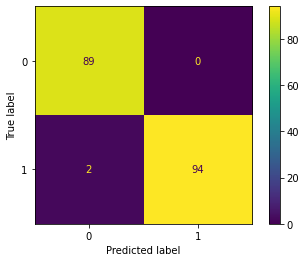

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

targets = []
predictions = []
for i, (x, y) in enumerate(test_dataloader):
  logits = model(x)
  predictions.extend(torch.argmax(logits, dim=1).numpy().tolist())
  targets.extend(y.numpy().tolist())

ConfusionMatrixDisplay.from_predictions(targets, predictions)